# ERROR ANALYSIS


1.   confusion matrix against emotions
2.   confusion matrix against triggers
3.   misclassified examples of single utterances
4.   emotion table performances model comparison
5.   sorting dialogues based on dialogue-wise accuracy (like getting how hard a whole dialogue is)
6.   get trigger effect comparison (check accuracy of emotions in utterances just after a correctly detected trigger utterance (in the same dialouge) vs check accuracy of emotions in utterances after bad detected trigger)
7.   table of performances (custom metrics (can be added others))

In [2]:
from src import error

In [3]:
import torch
from transformers import LlamaTokenizer, LlamaForSequenceClassification, LlamaModel, LlamaForCausalLM, AutoConfig, AutoModel
from accelerate import infer_auto_device_map, init_empty_weights
from tqdm.notebook import tqdm

In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import numpy as np
import torch
import urllib
from src.utils import *
from src.models.baseline import Baseline
from torch import nn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from datasets import Dataset, concatenate_datasets
from tqdm import tqdm
from transformers import BertLayer, AutoModelForSequenceClassification, DefaultDataCollator, AutoTokenizer, AutoConfig, TrainingArguments, Trainer, BertConfig, BertModel, BertPreTrainedModel, RobertaConfig, RobertaModel;

In [5]:
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [6]:
url = "https://drive.google.com/uc?export=download&id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2"
dataset_name = "MELD_train_efr.json"

df_manager = DataframeManager(url, dataset_name)

df = df_manager.produce_df()
df

Current work directory: c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref


,episode,emotions,utterances,triggers,emotions_id
0,utterance_0,"[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 5]"
1,utterance_1,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 5, 0, 0]"
2,utterance_2,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 2]"
3,utterance_3,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 2, 0, 5]"
4,utterance_4,"[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0, 0, 1, 0]","[5, 1, 5, 2]"
...,...,...,...,...,...
3995,utterance_3995,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 3, 0, 0, 5, 4, 0, 4, 5, 0, 0, 4]"
3996,utterance_3996,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 3, 0, 0, 5, 4, 0, 4, 5, 0, 0, 4, 4, 0]"
3997,utterance_3997,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 3, 0, 0, 5, 4, 0, 4, 5, 0, 0, 4, 4, 0, 0]"
3998,utterance_3998,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 3, 0, 0, 5, 4, 0, 4, 5, 0, 0, 4, 4, 0, 0, 5]"


In [7]:
train_df, val_df, test_df = df_manager.split_df(RANDOM_SEED)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3200, 5)
(400, 5)
(400, 5)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
train_df, val_df, test_df = df_manager.split_df(RANDOM_SEED)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3200, 5)
(400, 5)
(400, 5)


In [9]:
model_card = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir = "./model_dir/"+model_card+"/"
data_collator = DefaultDataCollator()

In [10]:
train_data_tokenized, val_data_tokenized, test_data_tokenized = df_manager.produce_dataset(tokenizer, RANDOM_SEED)

In [11]:
train_data_tokenized[0].keys()

dict_keys(['episode', 'emotions_id', 'triggers', 'dialogue_ids', 'dialogue_mask', 'dialogue_text', 'utterance_ids', 'utterance_mask', 'utterance_index'])

### PREPARING FAKE MODELS

In [12]:
from datasets import Dataset
ds = Dataset.from_pandas(df)
#concatenate targets
df_exploded = df.explode(['emotions_id','utterances', 'emotions', 'triggers'])
df_exploded['emotions_id'] = df_exploded['emotions_id']
ds_exploded = Dataset.from_pandas(df_exploded)

In [14]:
#model for df_exploded
import random
def model_43(ds):
    torch.manual_seed(43)
    a = torch.randn((len(ds),1,7))
    return a
def model_33(ds):
    torch.manual_seed(33)
    a = torch.randn((len(ds),1,7))
    return a
model1 = model_33
model2 = model_43
def same(ds):
    a = [item['emotions_id'] for item in ds]
    random.shuffle(a)
    h = [[np.eye(7)[i,:].tolist()] for i in a]
    return torch.tensor(h)
model3 = same
def major(ds):
    a = [item['emotions_id'] for item in ds]
    f = max(set(a), key=a.count)
    h = [[np.eye(7)[f,:].tolist()] for i in a]
    return torch.tensor(h)
model4 = major
def perfect(ds):
    a = [item['emotions_id'] for item in ds]
    h = [[np.eye(7)[i,:].tolist()] for i in a]
    return torch.tensor(h)
model5 = perfect

In [15]:
#models for train_data_tokenized
def model_43(ds):
    torch.manual_seed(43)
    a = torch.randn((len(ds),1,7))
    return a
def model_33(ds):
    torch.manual_seed(33)
    a = torch.randn((len(ds),1,7))
    return a
model1 = model_33
model2 = model_43
def same(ds):
    a = [item['emotions_id'] for item in ds]
    random.shuffle(a)
    h = [[i] for i in a]
    return torch.tensor(h).type(torch.float)
model3 = same
def major(ds):
    a = [item['emotions_id'] for item in ds]
    a = [x.index(max(x)) for x in a]
    f = max(set(a), key=a.count)
    h = [[np.eye(7)[f,:].tolist()] for i in a]
    return torch.tensor(h)
model4 = major
def perfect(ds):
    a = [item['emotions_id'] for item in ds]
    h = [[i] for i in a]
    return torch.tensor(h).type(torch.float)
model5 = perfect

#TRIGGER ONES

def model_43_t(ds):
    torch.manual_seed(43)
    a = torch.randn((len(ds),1))
    return a
def model_33_t(ds):
    torch.manual_seed(33)
    a = torch.randn((len(ds),1))
    return a
model1_t = model_33_t
model2_t = model_43_t
def same_t(ds):
    a = [item['triggers'] for item in ds]
    random.shuffle(a)
    h = [[i] for i in a]
    return torch.tensor(h).type(torch.float)
model3_t = same_t
def perfect_t(ds):
    a = [item['triggers'] for item in ds]
    h = [[i] for i in a]
    return torch.tensor(h).type(torch.float)
model5_t = perfect_t

In [16]:
model5_t(train_data_tokenized).shape

torch.Size([28062, 1])

In [17]:
df_exploded.sort_values('emotions_id').groupby(['emotions_id', 'emotions']).size()

emotions_id  emotions
0            neutral     15263
1            sadness      2648
2            fear         1114
3            joy          6317
4            disgust      1049
5            surprise     4645
6            anger        3964
dtype: int64

In [18]:
emotion_labels = [emotion for id, emotion in df_exploded.sort_values('emotions_id').groupby(['emotions_id', 'emotions']).groups.keys()]
emotion_labels

['neutral', 'sadness', 'fear', 'joy', 'disgust', 'surprise', 'anger']

# INIZIO TESTING

In [19]:
import importlib
importlib.reload(error)

<module 'src.error' from 'c:\\Users\\cacio\\Desktop\\jacopo\\scuola\\UNIBO MASTER\\NATURAL LANGUAGE PROCESSING\\project\\ediref\\src\\error.py'>

In [20]:
report = error.ErrorAnalysis(train_data_tokenized, emotion_labels=emotion_labels)

In [21]:
#model for exploded dataset
report.add_model(model1, train_data_tokenized, 'rand', seed = 33, type = 'emotions')
report.add_model(model4, train_data_tokenized, 'maj', type = 'emotions')
report.add_model(model3, train_data_tokenized, 'shuffle', type = 'emotions')
report.add_model(model5, train_data_tokenized, 'perfect', type = 'emotions')
report.add_model(model1_t, train_data_tokenized, 'rand', seed = 33, type = 'trigger')
report.add_model(model2_t, train_data_tokenized, 'rand', seed = 43, type = 'trigger')
report.add_model(model3_t, train_data_tokenized, 'shuffle', type = 'trigger')
report.add_model(model5_t, train_data_tokenized, 'perfect', type = 'trigger')

'Successfullty added model!'

In [22]:
report.df

,episode,emotions_id,triggers,dialogue_ids,dialogue_mask,dialogue_text,utterance_ids,utterance_mask,utterance_index,utterance_text,rand_33,maj_42,shuffle_42,perfect_42,rand_33_t,rand_43_t,shuffle_42_t,perfect_42_t
0,utterance_555,1,0,"[101, 2298, 1010, 1045, 2514, 2428, 2919, 2055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","Look, I feel really bad about how I freaked yo...","[101, 2298, 1010, 1045, 2514, 2428, 2919, 2055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"Look, I feel really bad about how I freaked yo...","[[tensor(0.6014), tensor(0.1087), tensor(-0.44...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",[tensor(0.6014)],[tensor(-0.0166)],[tensor(0.)],[tensor(0.)]
1,utterance_555,6,0,"[101, 2298, 1010, 1045, 2514, 2428, 2919, 2055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","Look, I feel really bad about how I freaked yo...","[101, 2175, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,Go!,"[[tensor(0.0631), tensor(-1.2514), tensor(1.27...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(1...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",[tensor(0.1087)],[tensor(-0.4668)],[tensor(0.)],[tensor(0.)]
2,utterance_3491,5,0,"[101, 2017, 1011, 2017, 29337, 2018, 3348, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","You-you you had sex with Ursula?! [SEP] Uh, a ...","[101, 2017, 1011, 2017, 29337, 2018, 3348, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",0,You-you you had sex with Ursula?!,"[[tensor(0.2888), tensor(0.5565), tensor(-0.44...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(1.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",[tensor(-0.4499)],[tensor(2.0909)],[tensor(0.)],[tensor(0.)]
3,utterance_3491,2,0,"[101, 2017, 1011, 2017, 29337, 2018, 3348, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","You-you you had sex with Ursula?! [SEP] Uh, a ...","[101, 7910, 1010, 1037, 2210, 2978, 1012, 2016...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"Uh, a little bit. She-she-she walked in and I ...","[[tensor(1.3365), tensor(-0.5728), tensor(0.53...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(1.), tensor(0...",[tensor(0.7841)],[tensor(0.6149)],[tensor(0.)],[tensor(0.)]
4,utterance_3491,5,1,"[101, 2017, 1011, 2017, 29337, 2018, 3348, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","You-you you had sex with Ursula?! [SEP] Uh, a ...","[101, 2017, 2134, 1005, 1056, 5060, 2016, 2001...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",2,You didn't notice she was wearing different cl...,"[[tensor(-0.1966), tensor(-0.7767), tensor(-1....","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",[tensor(0.6550)],[tensor(-0.5621)],[tensor(0.)],[tensor(1.)]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28057,utterance_3685,0,0,"[101, 2008, 2001, 6429, 1012, 102, 1045, 2113,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","That was amazing. [SEP] I know. [SEP] Hey, do ...","[101, 1045, 2113, 1012, 102, 0, 0, 0, 0, 0, 0,...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,I know.,"[[tensor(-1.2496), tensor(-0.6649), tensor(0.4...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[tensor(1.2972)],[tensor(-1.5649)],[tensor(0.)],[tensor(0.)]
28058,utterance_3685,3,0,"[101, 2008, 2001, 6429, 1012, 102, 1045, 2113,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","That was amazing. [SEP] I know. [SEP] Hey, do ...","[101, 4931, 1010

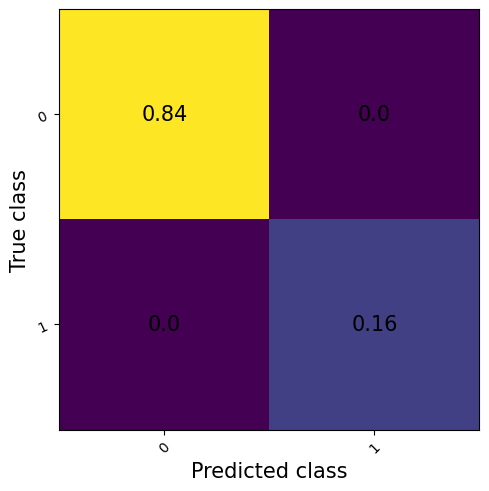

tensor([[0.8415, 0.0000],
        [0.0000, 0.1585]])

In [23]:
report.get_confusion_matrix('perfect_42_t')

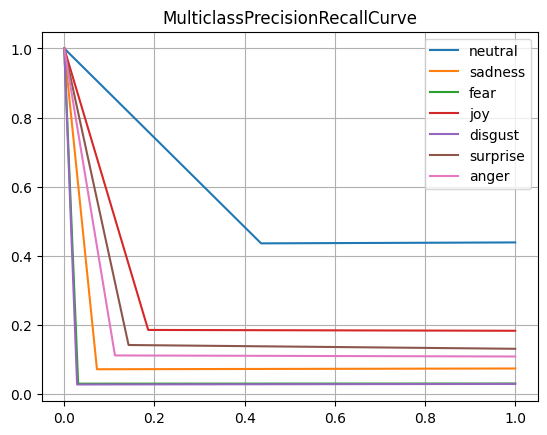

(tensor([[0.4392, 0.4365, 0.4365, 0.4365, 0.4365, 0.4365, 0.4365, 0.4365, 0.4365,
          0.4365, 0.4365, 0.4365, 0.4365, 0.4365, 0.4365, 0.4365, 0.4365, 0.4365,
          0.4365, 0.4365, 1.0000],
         [0.0747, 0.0725, 0.0725, 0.0725, 0.0725, 0.0725, 0.0725, 0.0725, 0.0725,
          0.0725, 0.0725, 0.0725, 0.0725, 0.0725, 0.0725, 0.0725, 0.0725, 0.0725,
          0.0725, 0.0725, 1.0000],
         [0.0312, 0.0308, 0.0308, 0.0308, 0.0308, 0.0308, 0.0308, 0.0308, 0.0308,
          0.0308, 0.0308, 0.0308, 0.0308, 0.0308, 0.0308, 0.0308, 0.0308, 0.0308,
          0.0308, 0.0308, 1.0000],
         [0.1838, 0.1862, 0.1862, 0.1862, 0.1862, 0.1862, 0.1862, 0.1862, 0.1862,
          0.1862, 0.1862, 0.1862, 0.1862, 0.1862, 0.1862, 0.1862, 0.1862, 0.1862,
          0.1862, 0.1862, 1.0000],
         [0.0300, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285,
          0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.0285,
          0.0285, 0.0285, 1.0000],
     

In [24]:
report.get_precision_recall('shuffle')

In [25]:
table = report.get_performance_table(metrics = ['accuracy','f1_macro','f1_micro','f1_weighted'])
report_df = pd.DataFrame(table.values())
report_df = report_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
report_df

rand_33
maj_42
shuffle_42
perfect_42
rand_43
tensor(0.1439)
tensor(0.1429)
tensor(0.1442)
tensor(1.)
nan
tensor(0.1443)
tensor(0.4392)
tensor(0.2642)
tensor(1.)
nan
tensor(0.1197)
tensor(0.0872)
tensor(0.1442)
tensor(1.)
nan
tensor(0.1690)
tensor(0.2681)
tensor(0.2642)
tensor(1.)
nan
tensor(0.4994)
nan
tensor(0.7335)
tensor(1.)
tensor(0.4992)
tensor(0.2426)
nan
tensor(0.1594)
tensor(1.)
tensor(0.2418)


,name,accuracy,f1_micro,f1_macro,f1_weighted,accuracy_t,f1_t
0,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None


In [26]:
model_name = 'rand_33' #need fullname with_seed
miss_df = report.get_misclassified(model_name=model_name, seed= 33)
miss_df[model_name] = miss_df[model_name].map(lambda x: x.argmax())
miss_df[:5]

,episode,emotions_id,triggers,dialogue_ids,dialogue_mask,dialogue_text,utterance_ids,utterance_mask,utterance_index,utterance_text,rand_33
0,utterance_555,1,0,"[101, 2298, 1010, 1045, 2514, 2428, 2919, 2055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","Look, I feel really bad about how I freaked yo...","[101, 2298, 1010, 1045, 2514, 2428, 2919, 2055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"Look, I feel really bad about how I freaked yo...",tensor(6)
1,utterance_555,6,0,"[101, 2298, 1010, 1045, 2514, 2428, 2919, 2055...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","Look, I feel really bad about how I freaked yo...","[101, 2175, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,Go!,tensor(2)
2,utterance_3491,5,0,"[101, 2017, 1011, 2017, 29337, 2018, 3348, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","You-you you had sex with Ursula?! [SEP] Uh, a ...","[101, 2017, 1011, 2017, 29337, 2018, 3348, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",0,You-you you had sex with Ursula?!,tensor(4)
3,utterance_3491,2,0,"[101, 2017, 1011, 2017, 29337, 2018, 3348, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","You-you you had sex with Ursula?! [SEP] Uh, a ...","[101, 7910, 1010, 1037, 2210, 2978, 1012, 2016...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"Uh, a little bit. She-she-she walked in and I ...",tensor(0)
5,utterance_3491,1,0,"[101, 2017, 1011, 2017, 29337, 2018, 3348, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","You-you you had sex with Ursula?! [SEP] Uh, a ...","[101, 2092, 1045, 2001, 2074, 2061, 7568, 2000...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",3,Well I was just so excited to see you.,tensor(4)


In [27]:
table = report.get_emotions_table()
print(table)
report_df = pd.DataFrame(table.values())
report_df = report_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
report_df

{'rand_33': {'name': 'rand_33', 'neutral_acc': tensor(0.1486), 'sadness_acc': tensor(0.1231), 'fear_acc': tensor(0.1678), 'joy_acc': tensor(0.1435), 'disgust_acc': tensor(0.1435), 'surprise_acc': tensor(0.1439), 'anger_acc': tensor(0.1365), 'neutral_f1': tensor(0.2237), 'sadness_f1': tensor(0.0862), 'fear_f1': tensor(0.0602), 'joy_f1': tensor(0.1621), 'disgust_f1': tensor(0.0483), 'surprise_f1': tensor(0.1378), 'anger_f1': tensor(0.1195)}, 'maj_42': {'name': 'maj_42', 'neutral_acc': tensor(1.), 'sadness_acc': tensor(0.), 'fear_acc': tensor(0.), 'joy_acc': tensor(0.), 'disgust_acc': tensor(0.), 'surprise_acc': tensor(0.), 'anger_acc': tensor(0.), 'neutral_f1': tensor(0.6103), 'sadness_f1': tensor(0.), 'fear_f1': tensor(0.), 'joy_f1': tensor(0.), 'disgust_f1': tensor(0.), 'surprise_f1': tensor(0.), 'anger_f1': tensor(0.)}, 'shuffle_42': {'name': 'shuffle_42', 'neutral_acc': tensor(0.4365), 'sadness_acc': tensor(0.0725), 'fear_acc': tensor(0.0308), 'joy_acc': tensor(0.1862), 'disgust_acc'

,name,neutral_acc,sadness_acc,fear_acc,joy_acc,disgust_acc,surprise_acc,anger_acc,neutral_f1,sadness_f1,fear_f1,joy_f1,disgust_f1,surprise_f1,anger_f1
0,rand_33,0.148641,0.123092,0.167808,0.143494,0.143535,0.143939,0.136527,0.223660,0.086201,0.060221,0.162121,0.048274,0.137806,0.119526
1,maj_42,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.610345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,shuffle_42,0.436511,0.072519,0.030822,0.186155,0.028470,0.142587,0.112414,0.436511,0.072519,0.030822,0.186155,0.028470,0.142587,0.112414
3,perfect_42,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,rand_43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,support,12325.000000,2096.000000,876.000000,5157.000000,843.000000,3696.000000,3069.000000,12325.000000,2096.000000,876.000000,5157.000000,843.000000,3696.000000,3069.000000


In [28]:
report.get_utterance_ranking(model_name='rand_33')

,accuracy,dialogue_len
episode,,
utterance_2236,0.00,21.0
utterance_3205,0.00,21.0
utterance_712,0.00,20.0
utterance_1531,0.00,18.0
utterance_1718,0.00,18.0
...,...,...
utterance_2646,0.75,4.0
utterance_2856,0.75,4.0
utterance_969,0.75,4.0


In [29]:
report.get_trigger_effect(model_name='shuffle_42')

{'shuffle_42': {'emotion_accuracy': {'correct_t': 0.23272727272727273,
   'bad_t': 0.2409263740062219},
  'support': {'correct_t': 709, 'bad_t': 3739}}}

In [30]:
table = report.get_trigger_table()
values = [np.array([np.array([v for v in scores.values()]).flatten() for scores in model.values()]).flatten().tolist() for model in table.values()]
columns = next(iter(table.values())).keys()
sub_columns = next(iter(next(iter(table.values())).values())).keys()
indexes = table.keys()
report_df = pd.DataFrame(values, columns = pd.MultiIndex.from_product([tuple(columns), tuple(sub_columns)]), index=indexes)
report_df

emotion_accuracy             support        
                  correct_t     bad_t correct_t   bad_t
rand_33            0.132768  0.144897    1358.0  3090.0
shuffle_42         0.232727  0.240926     709.0  3739.0
perfect_42         1.000000  0.000000    4448.0     0.0

# FINE TESTING